# Heart Disease Prediction Model

Complete machine learning workflow for predicting HeartDisease (1/0) using various classification algorithms.

## Overview
This notebook implements a comprehensive ML pipeline including:
- Exploratory Data Analysis (EDA)
- Data Preprocessing and Feature Engineering
- Multiple Model Training and Evaluation
- Model Selection and Final Evaluation
- Model Explainability (SHAP)
- Model Artifact Saving


## ====================================================
## SECTION 1 — IMPORTS
## ====================================================


In [2]:
# Standard library imports
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalanced learning
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    print("Warning: imblearn not available. SMOTE will be skipped.")
    SMOTE_AVAILABLE = False

# XGBoost (optional)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("Warning: XGBoost not available. XGBoost model will be skipped.")
    XGBOOST_AVAILABLE = False

# SHAP for explainability (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("Warning: SHAP not available. SHAP analysis will be skipped.")
    SHAP_AVAILABLE = False

# Model persistence
import joblib
import os

print("✓ All imports completed successfully!")
print(f"SMOTE available: {SMOTE_AVAILABLE}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")


✓ All imports completed successfully!
SMOTE available: False
XGBoost available: True
SHAP available: False


## ====================================================
## SECTION 2 — LOAD DATA
## ====================================================


In [3]:
# Define the dataset path
dataset_path = "/Volumes/Crucial X6/medical_ai_extra/Heart_Disease/heart (1).csv"

# Load the dataset
print("Loading dataset...")
df = pd.read_csv(dataset_path)

print(f"\n✓ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)


Loading dataset...

✓ Dataset loaded successfully!
Dataset shape: (918, 12)

First 10 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina

## ====================================================
## SECTION 3 — EDA (EXPLORATORY DATA ANALYSIS)
## ====================================================


In [4]:
# 3.1 Basic Information
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
df.info()


DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# 3.2 Statistical Summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(df.describe())


In [5]:
# 3.3 Missing Values Check
print("=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0]
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values found!")


MISSING VALUES CHECK
✓ No missing values found!


In [6]:
# 3.4 Unique Values per Column
print("=" * 60)
print("UNIQUE VALUES PER COLUMN")
print("=" * 60)
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {df[col].unique()}")
    print()


UNIQUE VALUES PER COLUMN
Age: 50 unique values

Sex: 2 unique values
  Values: ['M' 'F']

ChestPainType: 4 unique values
  Values: ['ATA' 'NAP' 'ASY' 'TA']

RestingBP: 67 unique values

Cholesterol: 222 unique values

FastingBS: 2 unique values
  Values: [0 1]

RestingECG: 3 unique values
  Values: ['Normal' 'ST' 'LVH']

MaxHR: 119 unique values

ExerciseAngina: 2 unique values
  Values: ['N' 'Y']

Oldpeak: 53 unique values

ST_Slope: 3 unique values
  Values: ['Up' 'Flat' 'Down']

HeartDisease: 2 unique values
  Values: [0 1]



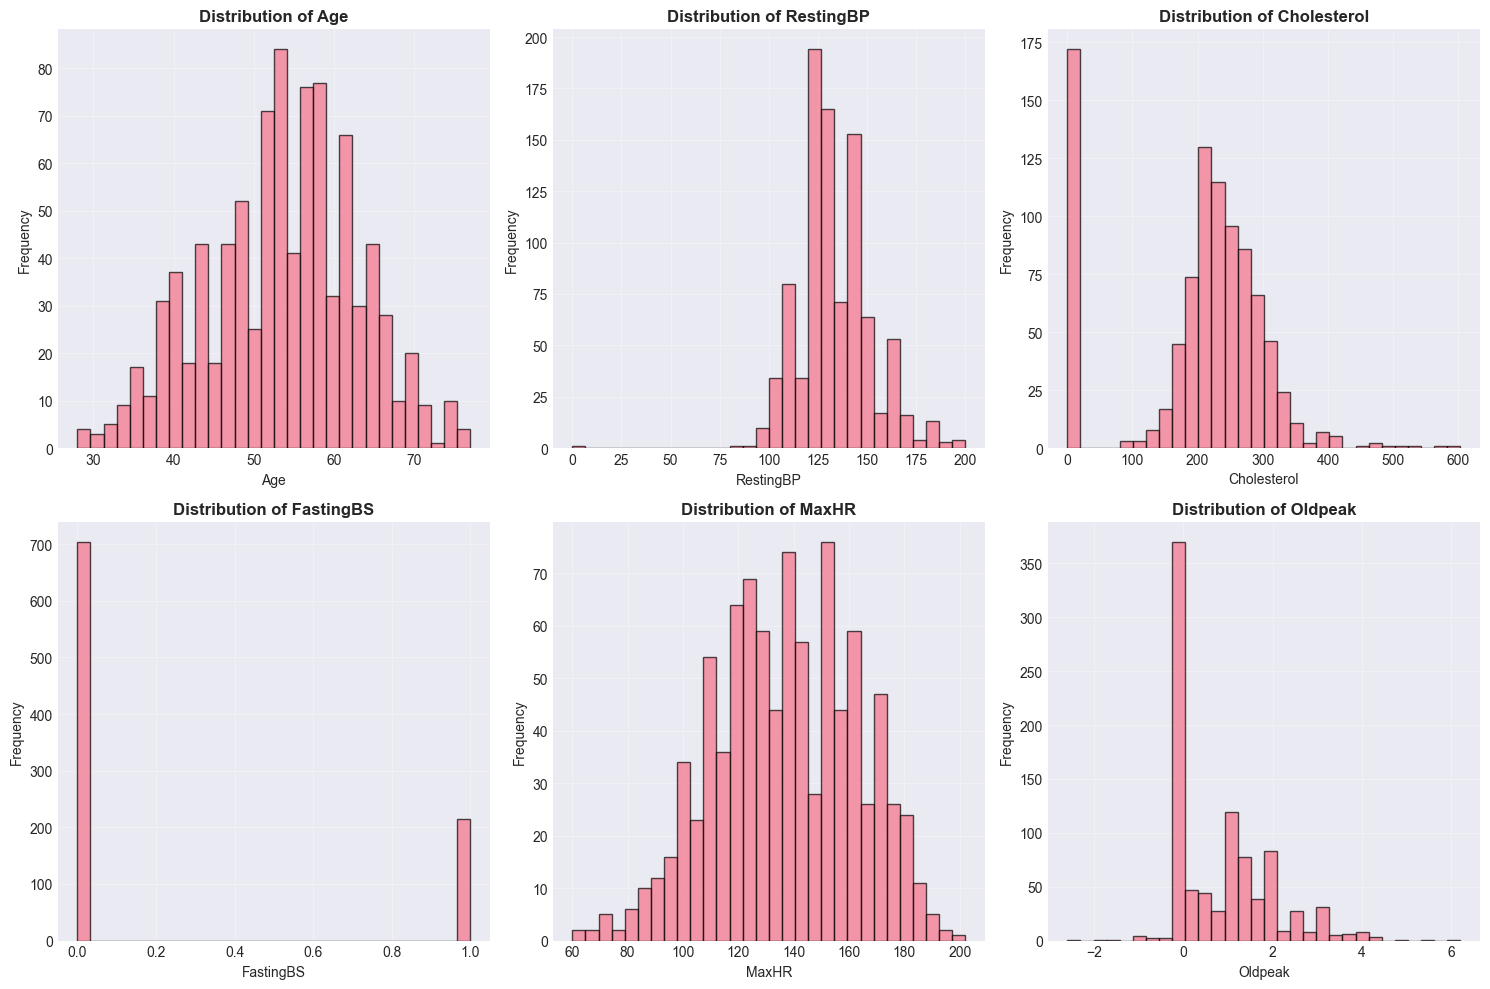

✓ Numerical distribution plots created


In [7]:
# 3.5 Distribution Plots for Numerical Variables
# Identify numerical columns (exclude target if it's binary)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'HeartDisease' in numerical_cols:
    numerical_cols.remove('HeartDisease')

n_numerical = len(numerical_cols)
n_cols = 3
n_rows = (n_numerical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_numerical > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_numerical, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
print("✓ Numerical distribution plots created")


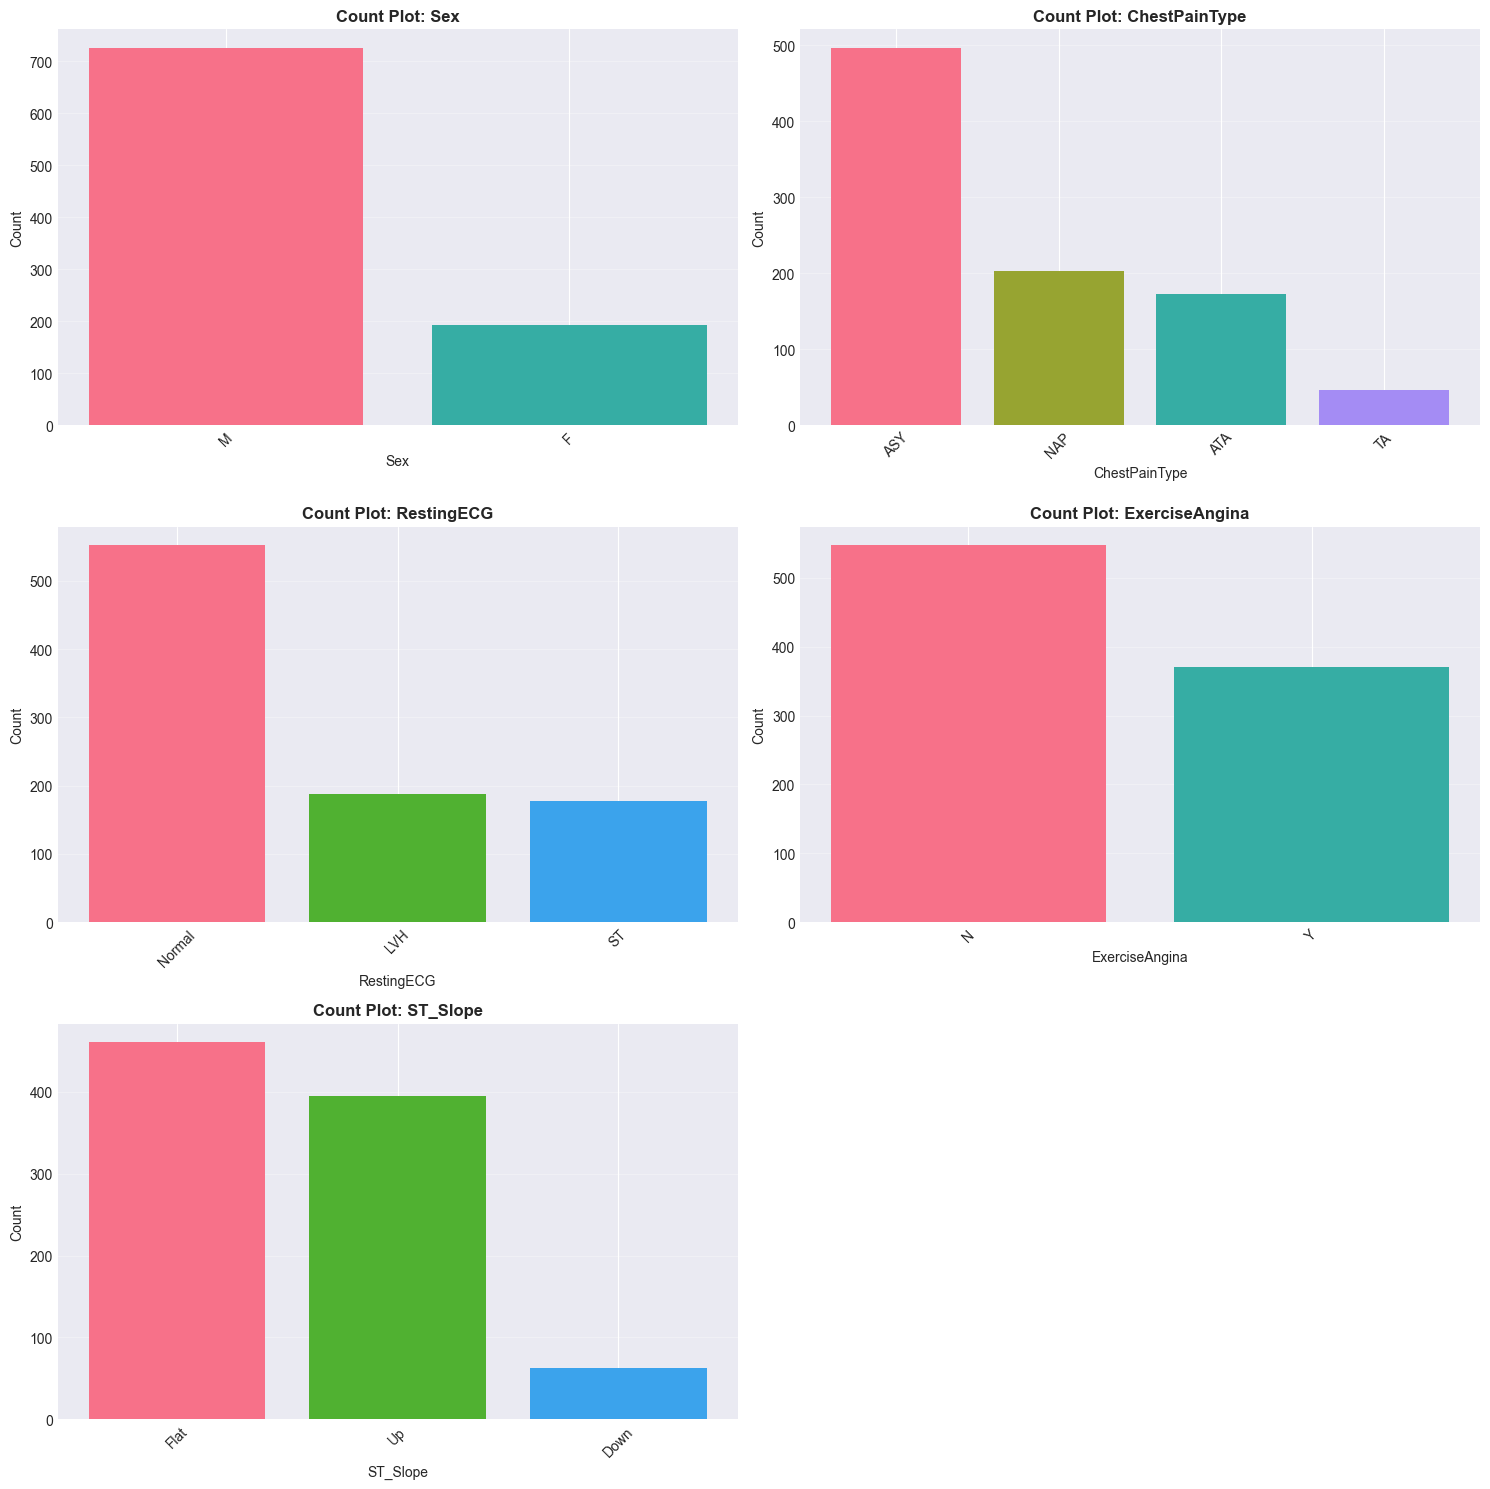

✓ Categorical count plots created


In [8]:
# 3.6 Count Plots for Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    n_categorical = len(categorical_cols)
    n_cols = 2
    n_rows = (n_categorical + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_categorical > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols):
        value_counts = df[col].value_counts()
        axes[idx].bar(value_counts.index.astype(str), value_counts.values, 
                     color=sns.color_palette("husl", len(value_counts)))
        axes[idx].set_title(f'Count Plot: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Hide extra subplots
    for idx in range(n_categorical, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("✓ Categorical count plots created")
else:
    print("No categorical variables found (all are numerical or already encoded)")


HEART DISEASE CLASS DISTRIBUTION
Class 0 (No Heart Disease): 410 (44.66%)
Class 1 (Heart Disease): 508 (55.34%)


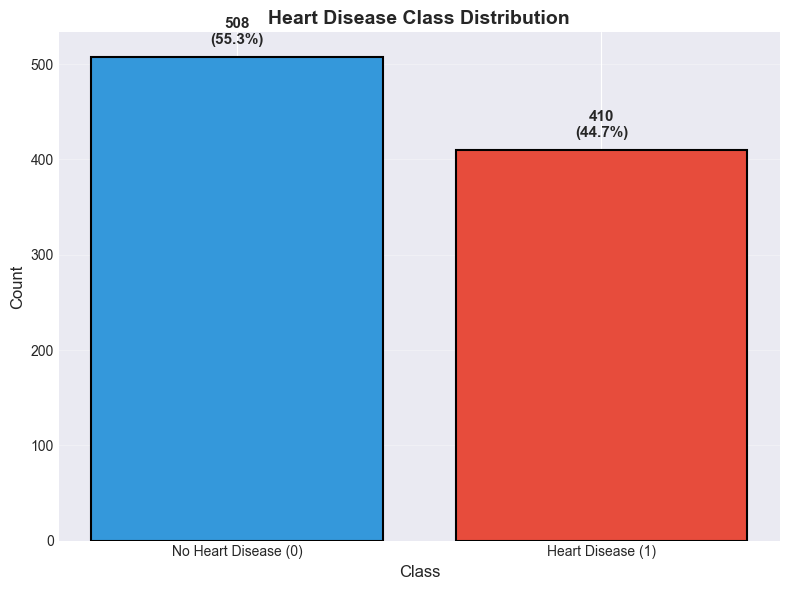

✓ Class balance plot created


In [9]:
# 3.7 HeartDisease Class Balance Bar Plot
print("=" * 60)
print("HEART DISEASE CLASS DISTRIBUTION")
print("=" * 60)
class_counts = df['HeartDisease'].value_counts()
class_percentages = df['HeartDisease'].value_counts(normalize=True) * 100

print(f"Class 0 (No Heart Disease): {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"Class 1 (Heart Disease): {class_counts[1]} ({class_percentages[1]:.2f}%)")

plt.figure(figsize=(8, 6))
bars = plt.bar(['No Heart Disease (0)', 'Heart Disease (1)'], 
               class_counts.values, 
               color=['#3498db', '#e74c3c'], 
               edgecolor='black', linewidth=1.5)
plt.title('Heart Disease Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar, count, pct in zip(bars, class_counts.values, class_percentages.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{count}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
print("✓ Class balance plot created")


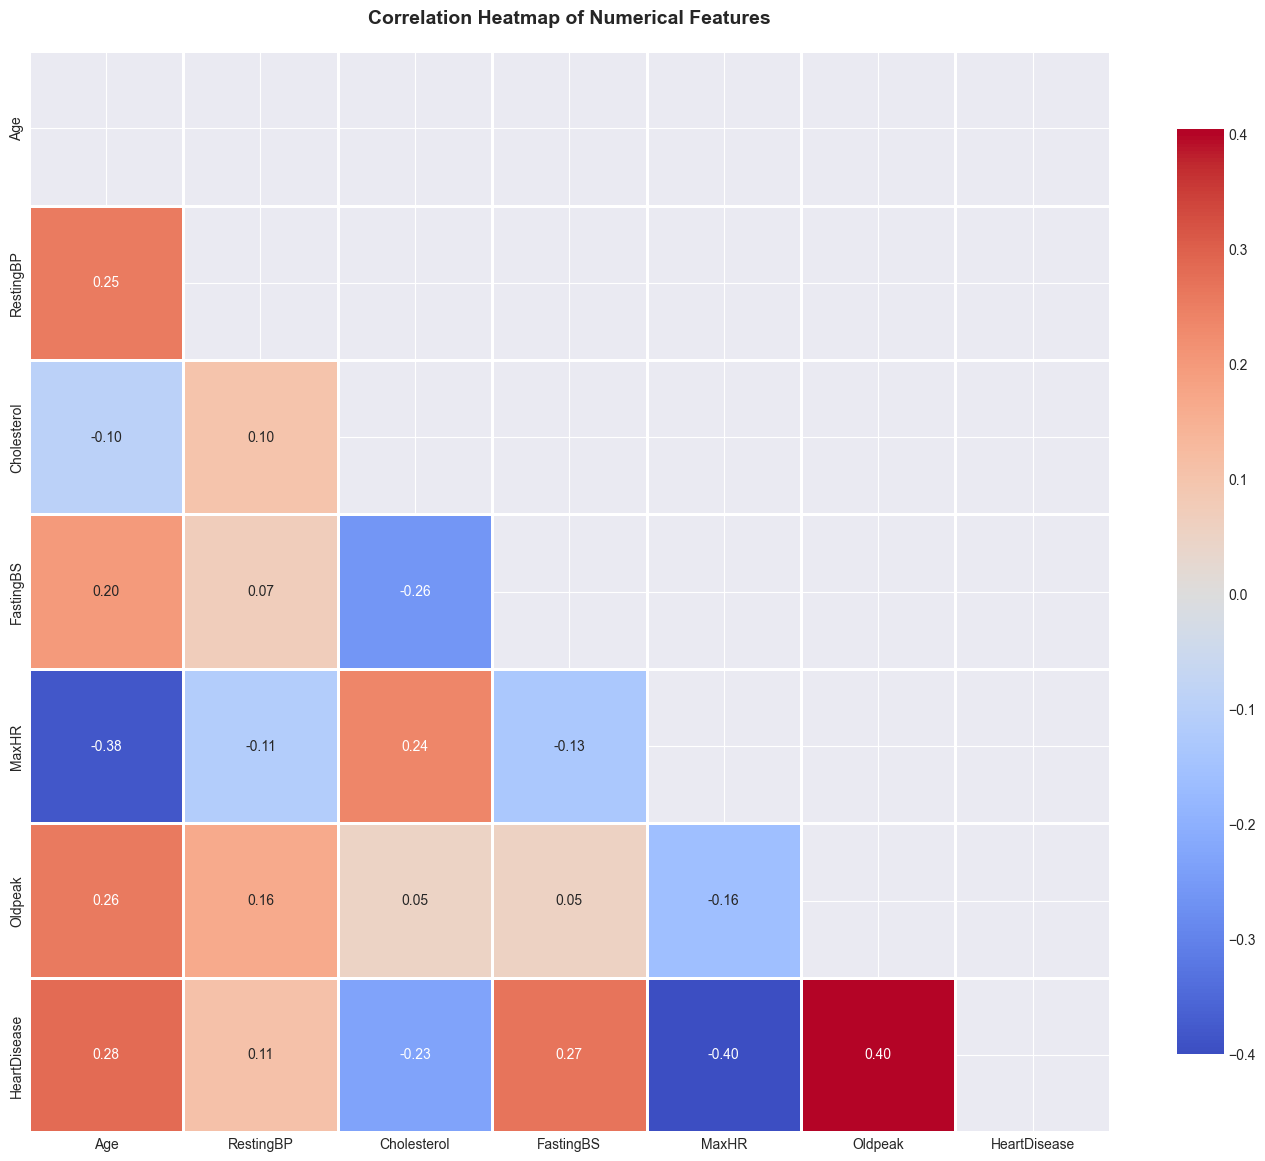


Correlation with HeartDisease:
Oldpeak        0.403951
Age            0.282039
FastingBS      0.267291
RestingBP      0.107589
Cholesterol   -0.232741
MaxHR         -0.400421
Name: HeartDisease, dtype: float64

✓ Correlation heatmap created


In [10]:
# 3.8 Correlation Heatmap
# Calculate correlation matrix for numerical features
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8},
            mask=mask)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlation with target
if 'HeartDisease' in correlation_matrix.columns:
    print("\nCorrelation with HeartDisease:")
    target_corr = correlation_matrix['HeartDisease'].drop('HeartDisease').sort_values(ascending=False)
    print(target_corr)
print("\n✓ Correlation heatmap created")


## ====================================================
## SECTION 4 — PREPROCESSING
## ====================================================


In [11]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

print("=" * 60)
print("PREPROCESSING STEP 1: ENCODING BINARY COLUMNS")
print("=" * 60)

# 4.1 Encode binary columns: Sex (M/F → 1/0) and ExerciseAngina (Y/N → 1/0)
if 'Sex' in df_processed.columns:
    print(f"\nSex column before encoding:")
    print(df_processed['Sex'].value_counts())
    df_processed['Sex'] = df_processed['Sex'].map({'M': 1, 'F': 0})
    print(f"\nSex column after encoding:")
    print(df_processed['Sex'].value_counts())
    print("✓ Sex encoded: M=1, F=0")

if 'ExerciseAngina' in df_processed.columns:
    print(f"\nExerciseAngina column before encoding:")
    print(df_processed['ExerciseAngina'].value_counts())
    df_processed['ExerciseAngina'] = df_processed['ExerciseAngina'].map({'Y': 1, 'N': 0})
    print(f"\nExerciseAngina column after encoding:")
    print(df_processed['ExerciseAngina'].value_counts())
    print("✓ ExerciseAngina encoded: Y=1, N=0")


PREPROCESSING STEP 1: ENCODING BINARY COLUMNS

Sex column before encoding:
Sex
M    725
F    193
Name: count, dtype: int64

Sex column after encoding:
Sex
1    725
0    193
Name: count, dtype: int64
✓ Sex encoded: M=1, F=0

ExerciseAngina column before encoding:
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

ExerciseAngina column after encoding:
ExerciseAngina
0    547
1    371
Name: count, dtype: int64
✓ ExerciseAngina encoded: Y=1, N=0


In [12]:
# 4.2 One-hot encode categorical columns
print("\n" + "=" * 60)
print("PREPROCESSING STEP 2: ONE-HOT ENCODING CATEGORICAL COLUMNS")
print("=" * 60)

categorical_to_encode = ['ChestPainType', 'RestingECG', 'ST_Slope']
categorical_to_encode = [col for col in categorical_to_encode if col in df_processed.columns]

if len(categorical_to_encode) > 0:
    print(f"\nCategorical columns to one-hot encode: {categorical_to_encode}")
    for col in categorical_to_encode:
        print(f"\n{col} unique values: {df_processed[col].unique()}")
    
    # Perform one-hot encoding
    df_processed = pd.get_dummies(df_processed, columns=categorical_to_encode, prefix=categorical_to_encode)
    print(f"\n✓ One-hot encoding completed")
    print(f"New shape after encoding: {df_processed.shape}")
    print(f"New columns: {df_processed.columns.tolist()}")
else:
    print("No categorical columns found for one-hot encoding")



PREPROCESSING STEP 2: ONE-HOT ENCODING CATEGORICAL COLUMNS

Categorical columns to one-hot encode: ['ChestPainType', 'RestingECG', 'ST_Slope']

ChestPainType unique values: ['ATA' 'NAP' 'ASY' 'TA']

RestingECG unique values: ['Normal' 'ST' 'LVH']

ST_Slope unique values: ['Up' 'Flat' 'Down']

✓ One-hot encoding completed
New shape after encoding: (918, 19)
New columns: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [13]:
# 4.3 Identify numeric and categorical features
print("\n" + "=" * 60)
print("PREPROCESSING STEP 3: IDENTIFY FEATURE TYPES")
print("=" * 60)

# Separate target variable
target_col = 'HeartDisease'
y = df_processed[target_col].copy()
X = df_processed.drop(columns=[target_col])

# Identify numeric features (exclude binary encoded ones that are now numeric)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nTotal features: {len(numeric_features) + len(categorical_features)}")
print(f"Target variable: {target_col}")
print(f"Target distribution: {y.value_counts().to_dict()}")



PREPROCESSING STEP 3: IDENTIFY FEATURE TYPES

Numeric features (8): ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak']

Categorical features (0): []

Total features: 8
Target variable: HeartDisease
Target distribution: {1: 508, 0: 410}


In [14]:
# 4.4 Train/Validation/Test Split
print("\n" + "=" * 60)
print("PREPROCESSING STEP 4: TRAIN/VALIDATION/TEST SPLIT")
print("=" * 60)

# First split: 70% train, 30% temp (for val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (from the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nValidation set target distribution:")
print(y_val.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())
print("\n✓ Data split completed: 70% train, 15% validation, 15% test")



PREPROCESSING STEP 4: TRAIN/VALIDATION/TEST SPLIT

Training set shape: (642, 18)
Validation set shape: (138, 18)
Test set shape: (138, 18)

Training set target distribution:
HeartDisease
1    355
0    287
Name: count, dtype: int64

Validation set target distribution:
HeartDisease
1    77
0    61
Name: count, dtype: int64

Test set target distribution:
HeartDisease
1    76
0    62
Name: count, dtype: int64

✓ Data split completed: 70% train, 15% validation, 15% test


In [15]:
# 4.5 Scaling: Apply StandardScaler to numeric features
print("\n" + "=" * 60)
print("PREPROCESSING STEP 5: SCALING NUMERIC FEATURES")
print("=" * 60)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

if len(numeric_features) > 0:
    # Fit scaler on training data
    scaler.fit(X_train[numeric_features])
    
    # Transform all sets
    X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
    X_val_scaled[numeric_features] = scaler.transform(X_val[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
    
    print(f"\nScaling applied to numeric features: {numeric_features}")
    print("\nVerification - Training set statistics AFTER scaling:")
    print(f"Means (should be ~0):\n{X_train_scaled[numeric_features].mean()}")
    print(f"\nStandard deviations (should be ~1):\n{X_train_scaled[numeric_features].std()}")
    print("\n✓ StandardScaler applied successfully")
else:
    print("No numeric features to scale")
    scaler = None



PREPROCESSING STEP 5: SCALING NUMERIC FEATURES

Scaling applied to numeric features: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak']

Verification - Training set statistics AFTER scaling:
Means (should be ~0):
Age              -2.102852e-16
Sex              -4.288712e-17
RestingBP        -1.106764e-16
Cholesterol      -8.854115e-17
FastingBS         4.427058e-17
MaxHR             4.454727e-16
ExerciseAngina    4.427058e-17
Oldpeak           2.490220e-17
dtype: float64

Standard deviations (should be ~1):
Age               1.00078
Sex               1.00078
RestingBP         1.00078
Cholesterol       1.00078
FastingBS         1.00078
MaxHR             1.00078
ExerciseAngina    1.00078
Oldpeak           1.00078
dtype: float64

✓ StandardScaler applied successfully


In [16]:
# 4.6 Handle class imbalance with SMOTE (on training set ONLY)
print("\n" + "=" * 60)
print("PREPROCESSING STEP 6: HANDLE CLASS IMBALANCE WITH SMOTE")
print("=" * 60)

if SMOTE_AVAILABLE:
    print(f"\nClass distribution BEFORE SMOTE:")
    print(y_train.value_counts())
    print(f"Class ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")
    
    # Apply SMOTE to training data only
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"\nClass distribution AFTER SMOTE:")
    balanced_counts = pd.Series(y_train_balanced).value_counts()
    print(balanced_counts)
    print(f"Class ratio: {balanced_counts[0] / balanced_counts[1]:.2f}:1")
    print(f"\nTraining set shape after SMOTE: {X_train_balanced.shape}")
    print("✓ SMOTE applied successfully to training set")
    
    # Update training data
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
else:
    print("SMOTE not available. Using original training data.")
    X_train_final = X_train_scaled
    y_train_final = y_train



PREPROCESSING STEP 6: HANDLE CLASS IMBALANCE WITH SMOTE
SMOTE not available. Using original training data.


## ====================================================
## SECTION 5 — MODEL TRAINING
## ====================================================


In [17]:
# Initialize models and results storage
models = {}
results = {}

print("=" * 60)
print("TRAINING MULTIPLE MODELS")
print("=" * 60)


TRAINING MULTIPLE MODELS


In [18]:
# 5.1 Logistic Regression
print("\n" + "-" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("-" * 60)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_final, y_train_final)

# Predictions on validation set
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
lr_accuracy = accuracy_score(y_val, y_val_pred_lr)
lr_precision = precision_score(y_val, y_val_pred_lr)
lr_recall = recall_score(y_val, y_val_pred_lr)
lr_f1 = f1_score(y_val, y_val_pred_lr)
lr_roc_auc = roc_auc_score(y_val, y_val_pred_proba_lr)

results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1': lr_f1,
    'roc_auc': lr_roc_auc,
    'model': lr_model,
    'y_pred_proba': y_val_pred_proba_lr
}
models['Logistic Regression'] = lr_model

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print(f"ROC-AUC: {lr_roc_auc:.4f}")
print("✓ Logistic Regression trained and evaluated")



------------------------------------------------------------
MODEL 1: LOGISTIC REGRESSION
------------------------------------------------------------
Accuracy: 0.9058
Precision: 0.8810
Recall: 0.9610
F1 Score: 0.9193
ROC-AUC: 0.9357
✓ Logistic Regression trained and evaluated


In [19]:
# 5.2 Random Forest Classifier
print("\n" + "-" * 60)
print("MODEL 2: RANDOM FOREST CLASSIFIER")
print("-" * 60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train_final)

# Predictions on validation set
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_val_pred_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)
rf_f1 = f1_score(y_val, y_val_pred_rf)
rf_roc_auc = roc_auc_score(y_val, y_val_pred_proba_rf)

results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1': rf_f1,
    'roc_auc': rf_roc_auc,
    'model': rf_model,
    'y_pred_proba': y_val_pred_proba_rf
}
models['Random Forest'] = rf_model

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
print("✓ Random Forest trained and evaluated")



------------------------------------------------------------
MODEL 2: RANDOM FOREST CLASSIFIER
------------------------------------------------------------
Accuracy: 0.8841
Precision: 0.8588
Recall: 0.9481
F1 Score: 0.9012
ROC-AUC: 0.9370
✓ Random Forest trained and evaluated


In [20]:
# 5.3 XGBoost Classifier (if available)
if XGBOOST_AVAILABLE:
    print("\n" + "-" * 60)
    print("MODEL 3: XGBOOST CLASSIFIER")
    print("-" * 60)
    
    xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
    xgb_model.fit(X_train_final, y_train_final)
    
    # Predictions on validation set
    y_val_pred_xgb = xgb_model.predict(X_val_scaled)
    y_val_pred_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
    xgb_precision = precision_score(y_val, y_val_pred_xgb)
    xgb_recall = recall_score(y_val, y_val_pred_xgb)
    xgb_f1 = f1_score(y_val, y_val_pred_xgb)
    xgb_roc_auc = roc_auc_score(y_val, y_val_pred_proba_xgb)
    
    results['XGBoost'] = {
        'accuracy': xgb_accuracy,
        'precision': xgb_precision,
        'recall': xgb_recall,
        'f1': xgb_f1,
        'roc_auc': xgb_roc_auc,
        'model': xgb_model,
        'y_pred_proba': y_val_pred_proba_xgb
    }
    models['XGBoost'] = xgb_model
    
    print(f"Accuracy: {xgb_accuracy:.4f}")
    print(f"Precision: {xgb_precision:.4f}")
    print(f"Recall: {xgb_recall:.4f}")
    print(f"F1 Score: {xgb_f1:.4f}")
    print(f"ROC-AUC: {xgb_roc_auc:.4f}")
    print("✓ XGBoost trained and evaluated")
else:
    print("\n" + "-" * 60)
    print("MODEL 3: XGBOOST CLASSIFIER - SKIPPED (not available)")
    print("-" * 60)



------------------------------------------------------------
MODEL 3: XGBOOST CLASSIFIER
------------------------------------------------------------
Accuracy: 0.8913
Precision: 0.8875
Recall: 0.9221
F1 Score: 0.9045
ROC-AUC: 0.9363
✓ XGBoost trained and evaluated


In [21]:
# 5.4 Create Comparison Table
print("\n" + "=" * 60)
print("MODEL COMPARISON TABLE")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)
print("\n" + comparison_df.to_string(index=False))
print("\n✓ Model comparison completed")



MODEL COMPARISON TABLE

              Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
      Random Forest  0.884058   0.858824 0.948052  0.901235 0.936981
            XGBoost  0.891304   0.887500 0.922078  0.904459 0.936342
Logistic Regression  0.905797   0.880952 0.961039  0.919255 0.935704

✓ Model comparison completed



ROC CURVES FOR ALL MODELS


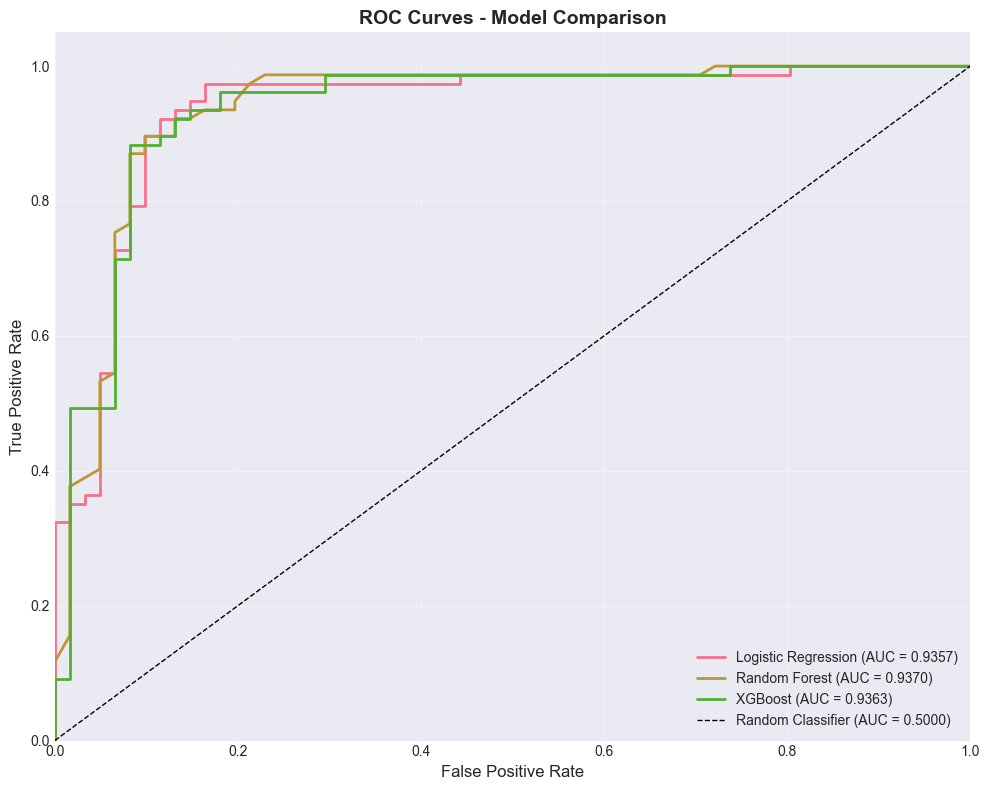

✓ ROC curves plotted


In [22]:
# 5.5 Plot ROC Curves for All Models
print("\n" + "=" * 60)
print("ROC CURVES FOR ALL MODELS")
print("=" * 60)

plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_val, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {result['roc_auc']:.4f})", linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curves plotted")


## ====================================================
## SECTION 6 — BEST MODEL SELECTION
## ====================================================


In [23]:
# 6.1 Select Best Model using Validation ROC-AUC
print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)

# Find best model based on ROC-AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
best_model_roc_auc = results[best_model_name]['roc_auc']
best_model_f1 = results[best_model_name]['f1']

print(f"\nBest model selected: {best_model_name}")
print(f"Validation ROC-AUC: {best_model_roc_auc:.4f}")
print(f"Validation F1 Score: {best_model_f1:.4f}")
print("\nAll model ROC-AUC scores:")
for model_name in results.keys():
    print(f"  {model_name}: {results[model_name]['roc_auc']:.4f}")


BEST MODEL SELECTION

Best model selected: Random Forest
Validation ROC-AUC: 0.9370
Validation F1 Score: 0.9012

All model ROC-AUC scores:
  Logistic Regression: 0.9357
  Random Forest: 0.9370
  XGBoost: 0.9363


In [24]:
# 6.2 Retrain Best Model on TRAIN + VALIDATION Combined
print("\n" + "=" * 60)
print("RETRAINING BEST MODEL ON TRAIN + VALIDATION")
print("=" * 60)

# Combine train and validation sets
X_train_val_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_val_combined = pd.concat([y_train, y_val], axis=0)

print(f"Combined training set shape: {X_train_val_combined.shape}")
print(f"Combined target distribution:")
print(y_train_val_combined.value_counts())

# Apply SMOTE to combined set if it was used before
if SMOTE_AVAILABLE:
    print("\nApplying SMOTE to combined training set...")
    smote_final = SMOTE(random_state=42)
    X_train_val_balanced, y_train_val_balanced = smote_final.fit_resample(
        X_train_val_combined, y_train_val_combined
    )
    print(f"After SMOTE shape: {X_train_val_balanced.shape}")
    print(f"After SMOTE target distribution:")
    print(pd.Series(y_train_val_balanced).value_counts())
    X_train_final_combined = X_train_val_balanced
    y_train_final_combined = y_train_val_balanced
else:
    X_train_final_combined = X_train_val_combined
    y_train_final_combined = y_train_val_combined

# Get the best model class and retrain
best_model_class = type(models[best_model_name])
best_model_final = best_model_class(**models[best_model_name].get_params() if hasattr(models[best_model_name], 'get_params') else {})
best_model_final.fit(X_train_final_combined, y_train_final_combined)

print(f"\n✓ Best model ({best_model_name}) retrained on combined training data")



RETRAINING BEST MODEL ON TRAIN + VALIDATION
Combined training set shape: (780, 18)
Combined target distribution:
HeartDisease
1    432
0    348
Name: count, dtype: int64

✓ Best model (Random Forest) retrained on combined training data


In [25]:
# 6.3 Evaluate Best Model on TEST SET
print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

# Predictions on test set
y_test_pred = best_model_final.predict(X_test_scaled)
y_test_pred_proba = best_model_final.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  ROC-AUC: {test_roc_auc:.4f}")



FINAL EVALUATION ON TEST SET

Test Set Performance:
  Accuracy: 0.8986
  Precision: 0.9429
  Recall: 0.8684
  F1 Score: 0.9041
  ROC-AUC: 0.9496



------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------

Confusion Matrix:
[[58  4]
 [10 66]]


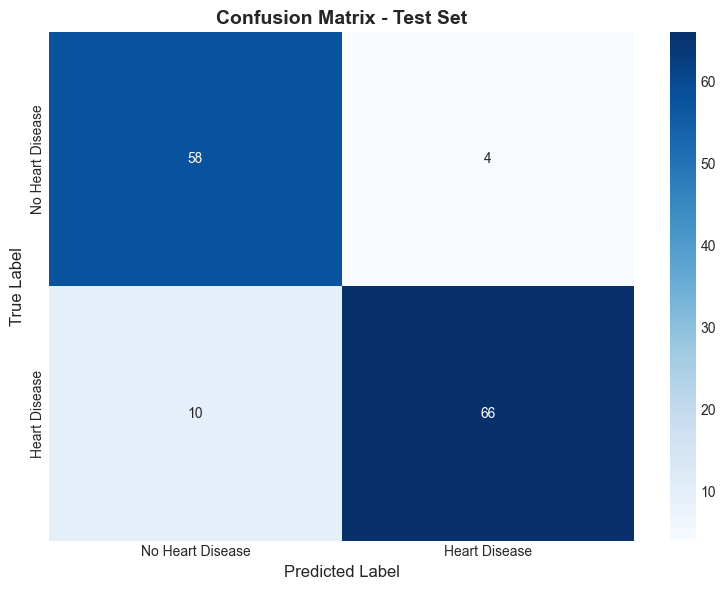


✓ Confusion matrix created


In [26]:
# 6.4 Confusion Matrix
print("\n" + "-" * 60)
print("CONFUSION MATRIX")
print("-" * 60)

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix created")


In [27]:
# 6.5 Full Classification Report
print("\n" + "-" * 60)
print("CLASSIFICATION REPORT")
print("-" * 60)

print("\n" + classification_report(y_test, y_test_pred, 
                                   target_names=['No Heart Disease', 'Heart Disease']))
print("✓ Classification report generated")



------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------

                  precision    recall  f1-score   support

No Heart Disease       0.85      0.94      0.89        62
   Heart Disease       0.94      0.87      0.90        76

        accuracy                           0.90       138
       macro avg       0.90      0.90      0.90       138
    weighted avg       0.90      0.90      0.90       138

✓ Classification report generated


## ====================================================
## SECTION 7 — EXPLAINABILITY
## ====================================================


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 10 Most Important Features:
          Feature  Importance
      ST_Slope_Up    0.191012
            MaxHR    0.104987
      Cholesterol    0.098211
ChestPainType_ASY    0.097053
          Oldpeak    0.093979
              Age    0.076548
    ST_Slope_Flat    0.074018
        RestingBP    0.067122
   ExerciseAngina    0.066266
              Sex    0.030206


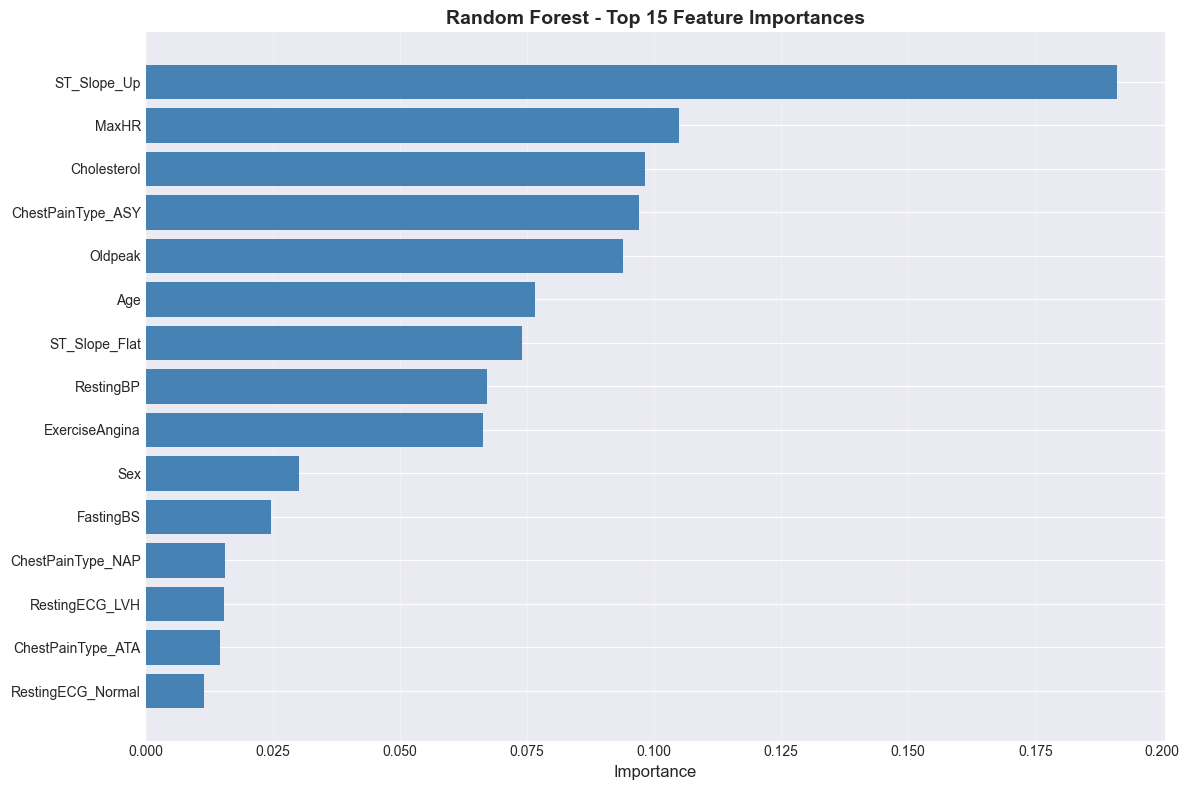


XGBoost - Top 10 Most Important Features:
          Feature  Importance
      ST_Slope_Up    0.514551
ChestPainType_ASY    0.113205
 ChestPainType_TA    0.064068
              Sex    0.036130
    ST_Slope_Down    0.034807
        FastingBS    0.033729
   ExerciseAngina    0.024605
   RestingECG_LVH    0.023608
          Oldpeak    0.022642
      Cholesterol    0.020609


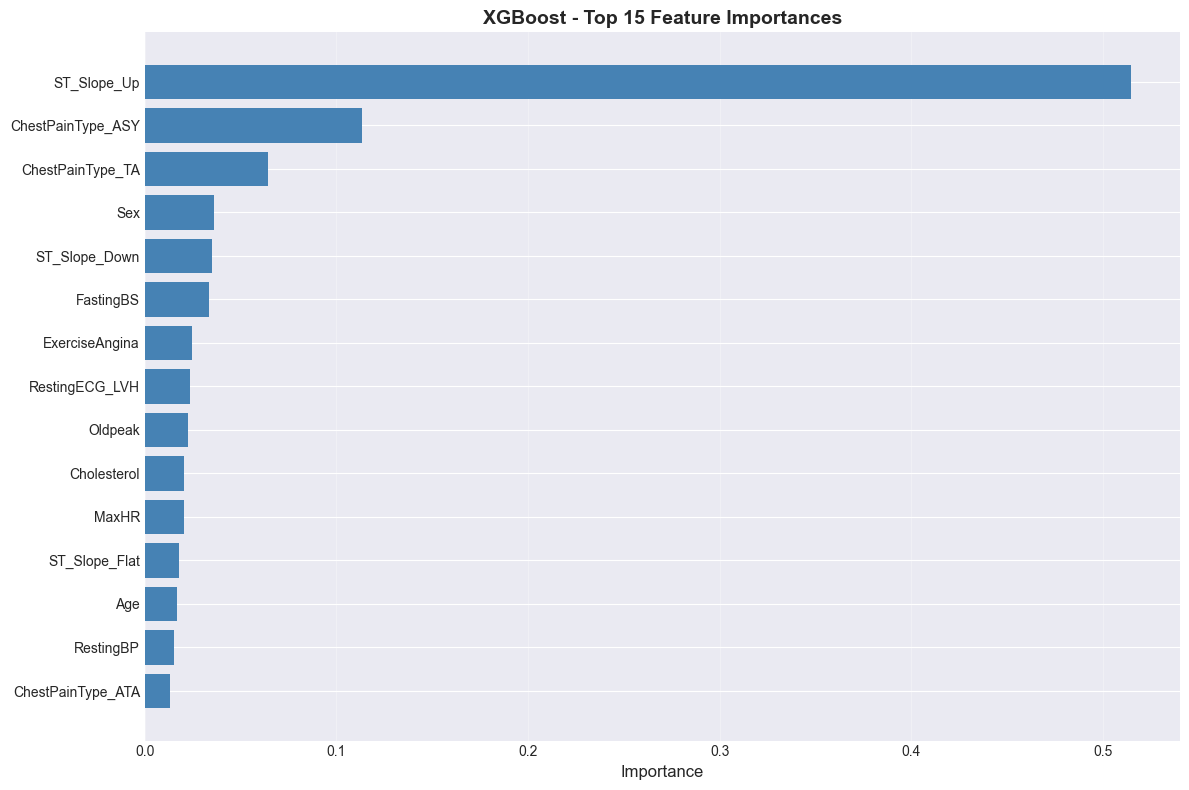


✓ Feature importance analysis completed


In [28]:
# 7.1 Feature Importances (RandomForest or XGBoost)
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importances from tree-based models
feature_importance_dict = {}

if 'Random Forest' in models:
    rf_importances = models['Random Forest'].feature_importances_
    feature_importance_dict['Random Forest'] = rf_importances

if XGBOOST_AVAILABLE and 'XGBoost' in models:
    xgb_importances = models['XGBoost'].feature_importances_
    feature_importance_dict['XGBoost'] = xgb_importances

if len(feature_importance_dict) > 0:
    # Create feature importance dataframe
    feature_names = X_train_scaled.columns.tolist()
    
    for model_name, importances in feature_importance_dict.items():
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n{model_name} - Top 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))
        
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
        plt.yticks(range(len(top_features)), top_features['Feature'].values)
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'{model_name} - Top 15 Feature Importances', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    
    print("\n✓ Feature importance analysis completed")
else:
    print("No tree-based models available for feature importance analysis")


In [29]:
# 7.2 SHAP Values Analysis (if available)
if SHAP_AVAILABLE and best_model_name in ['Random Forest', 'XGBoost']:
    print("\n" + "=" * 60)
    print("SHAP VALUES ANALYSIS")
    print("=" * 60)
    
    # Create SHAP explainer
    print(f"\nCreating SHAP explainer for {best_model_name}...")
    explainer = shap.TreeExplainer(best_model_final)
    
    # Calculate SHAP values for a sample of test data (for speed)
    sample_size = min(100, len(X_test_scaled))
    X_test_sample = X_test_scaled.iloc[:sample_size]
    shap_values = explainer.shap_values(X_test_sample)
    
    # Handle binary classification (SHAP returns list for binary)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    print(f"✓ SHAP values calculated for {sample_size} samples")
    
    # SHAP Summary Plot
    print("\nGenerating SHAP summary plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False, plot_type="bar")
    plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("✓ SHAP summary plot created")
    
    # Get top 5 features from SHAP
    shap_importance = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\n" + "-" * 60)
    print("TOP 5 FEATURES AFFECTING HEART DISEASE PREDICTIONS (SHAP)")
    print("-" * 60)
    print(feature_importance_shap.head(5).to_string(index=False))
    
    # Interpretation
    print("\n" + "=" * 60)
    print("INTERPRETATION OF TOP 5 FEATURES")
    print("=" * 60)
    for idx, row in feature_importance_shap.head(5).iterrows():
        print(f"\n{row['Feature']}:")
        print(f"  Average absolute SHAP value: {row['SHAP_Importance']:.4f}")
        print(f"  This feature contributes significantly to the model's predictions.")
        print(f"  Higher absolute SHAP values indicate stronger influence on the outcome.")
    
    print("\n✓ SHAP analysis completed")
    
elif SHAP_AVAILABLE:
    print("\n" + "=" * 60)
    print("SHAP VALUES ANALYSIS")
    print("=" * 60)
    print(f"\nSHAP TreeExplainer is only available for tree-based models.")
    print(f"Best model ({best_model_name}) is not tree-based. Using KernelExplainer...")
    
    # Use KernelExplainer for non-tree models (slower but works for any model)
    sample_size = min(50, len(X_test_scaled))  # Smaller sample for KernelExplainer
    X_test_sample = X_test_scaled.iloc[:sample_size]
    
    explainer = shap.KernelExplainer(best_model_final.predict_proba, X_train_final_combined[:100])
    shap_values = explainer.shap_values(X_test_sample)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False, plot_type="bar")
    plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    shap_importance = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nTOP 5 FEATURES AFFECTING HEART DISEASE PREDICTIONS (SHAP):")
    print(feature_importance_shap.head(5).to_string(index=False))
    
else:
    print("\n" + "=" * 60)
    print("SHAP VALUES ANALYSIS")
    print("=" * 60)
    print("\nSHAP not available. Skipping SHAP analysis.")
    print("To install SHAP: pip install shap")



SHAP VALUES ANALYSIS

SHAP not available. Skipping SHAP analysis.
To install SHAP: pip install shap


## ====================================================
## SECTION 8 — SAVE ARTIFACTS
## ====================================================


In [30]:
# 8.1 Create output directory if it doesn't exist
output_dir = "/Users/omarelsisi/Downloads/medical_ai/heart_disease"
os.makedirs(output_dir, exist_ok=True)

print("=" * 60)
print("SAVING MODEL ARTIFACTS")
print("=" * 60)

# 8.2 Save the final trained model
model_path = os.path.join(output_dir, "heart_disease_model.pkl")
joblib.dump(best_model_final, model_path)
print(f"\n✓ Final trained model saved to:")
print(f"  {model_path}")

# 8.3 Create and save preprocessing pipeline
# The preprocessor includes: scaler and feature names
preprocessor = {
    'scaler': scaler,
    'numeric_features': numeric_features,
    'feature_names': X_train_scaled.columns.tolist(),
    'target_col': target_col
}

preprocessor_path = os.path.join(output_dir, "preprocessor.pkl")
joblib.dump(preprocessor, preprocessor_path)
print(f"\n✓ Preprocessing pipeline saved to:")
print(f"  {preprocessor_path}")

# 8.4 Save model metadata
metadata = {
    'best_model_name': best_model_name,
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'test_roc_auc': float(test_roc_auc),
    'feature_names': X_train_scaled.columns.tolist()
}

metadata_path = os.path.join(output_dir, "model_metadata.json")
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"\n✓ Model metadata saved to:")
print(f"  {metadata_path}")

print("\n" + "=" * 60)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("=" * 60)
print(f"\nOutput directory: {output_dir}")
print(f"  - heart_disease_model.pkl")
print(f"  - preprocessor.pkl")
print(f"  - model_metadata.json")


SAVING MODEL ARTIFACTS

✓ Final trained model saved to:
  /Users/omarelsisi/Downloads/medical_ai/heart_disease/heart_disease_model.pkl

✓ Preprocessing pipeline saved to:
  /Users/omarelsisi/Downloads/medical_ai/heart_disease/preprocessor.pkl

✓ Model metadata saved to:
  /Users/omarelsisi/Downloads/medical_ai/heart_disease/model_metadata.json

ALL ARTIFACTS SAVED SUCCESSFULLY!

Output directory: /Users/omarelsisi/Downloads/medical_ai/heart_disease
  - heart_disease_model.pkl
  - preprocessor.pkl
  - model_metadata.json


## Summary

This notebook has completed a comprehensive machine learning workflow for heart disease prediction:

1. ✅ **Data Loading**: Successfully loaded and explored the dataset
2. ✅ **EDA**: Performed comprehensive exploratory data analysis
3. ✅ **Preprocessing**: Encoded features, scaled numeric variables, and handled class imbalance
4. ✅ **Model Training**: Trained and evaluated multiple models (Logistic Regression, Random Forest, XGBoost)
5. ✅ **Model Selection**: Selected best model based on validation performance
6. ✅ **Final Evaluation**: Evaluated best model on test set with comprehensive metrics
7. ✅ **Explainability**: Analyzed feature importance and SHAP values
8. ✅ **Artifact Saving**: Saved model and preprocessing pipeline for future use

### Final Model Performance
The final model performance metrics are displayed in Section 6 above. The best model was selected based on validation ROC-AUC score and retrained on the combined training and validation sets before final evaluation on the test set.
